# Project - Classification of Human Activities

Disciplina de Tópicos de Ciência de Dados

Joana Simões, nº 2019217013

In [95]:
# imports 
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, f1_score
import pandas as pd
from sklearn import preprocessing

## Exercise 1.1

In [2]:
def split_train_test(X, y, percentage_test=0.3):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=percentage_test, random_state=42)
    return x_train, x_test, y_train, y_test

In [3]:
def split_train_test_validation(X, y, percentage_test=0.3, percentage_validation=0.3):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=percentage_test, random_state=42)
    percent = (len(X)*percentage_validation) / len(x_train)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=percent)

    return x_train, x_val, x_test, y_train, y_val, y_test

In [4]:
def split_k_fold(X, y, k_folds):
    x_train = []
    x_test = []
    y_train = []
    y_test = []

    k_fold = KFold(n_splits=k_folds, random_state=42, shuffle=True)

    for train_index, test_index in k_fold.split(X):
        x_train.append(X.loc[train_index])
        y_train.append(y[train_index])
        x_test.append(X.loc[test_index])
        y_test.append(y[test_index])

    return x_train, x_test, y_train, y_test

## Exercise 1.2

In [64]:
def display_confusion_matrix(cm, labels, title=''):
    plt.figure()
    display = ConfusionMatrixDisplay(cm, display_labels=labels)
    display.plot()
    plt.title(title)
    plt.show()

In [65]:
def calculate_confusion_matrix(y, y_pred, labels=None, display=True, title=''):
    cm = confusion_matrix(y, y_pred, labels=labels)
    if display:
        display_confusion_matrix(cm, labels, title=title)
    return cm

In [7]:
def calculate_recall(y, y_pred, metric=None):
    score = recall_score(y, y_pred, average=metric)
    return score

In [8]:
def calculate_precision(y, y_pred, metric=None):
    return precision_score(y, y_pred, average=metric)

In [9]:
def calculate_f1(y, y_pred, metric=None):
    return f1_score(y, y_pred, average=metric)

In [110]:
np.array(recalls).shape

(15,)

In [115]:
recalls

[0.9615079365079366,
 0.9548412698412698,
 0.9738095238095238,
 0.9738095238095238,
 0.9785714285714285,
 0.9671428571428572,
 0.9585714285714285,
 0.979047619047619,
 0.9754761904761905,
 0.9838095238095239,
 0.9754761904761905,
 0.979047619047619,
 0.9754761904761905,
 0.9838095238095239,
 0.9704761904761905]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [120]:
def plot_measures(recalls, precisions, f1_scores, title=''):
    plt.figure()
    x = np.arange(len(recalls))+1
    plt.plot(x, recalls, label='Recall')
    plt.plot(x, precisions, label='Precision')
    plt.plot(x, f1_scores, label='F1 score')
    plt.xlabel('K values')
    plt.ylabel('Result')
    plt.title(title)
    plt.legend()
    plt.show()

In [11]:
y = np.array([1,2,1, 3, 2, 1, 1])
y_pred = np.array([1, 1, 1, 3, 2, 2, 1])

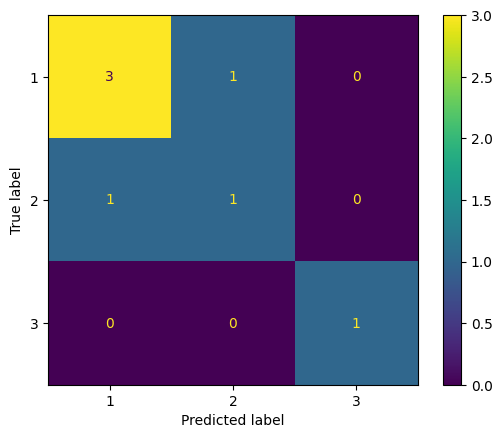

array([[3, 1, 0],
       [1, 1, 0],
       [0, 0, 1]], dtype=int64)

In [12]:
calculate_confusion_matrix(y, y_pred, labels=[1, 2, 3])

In [13]:
calculate_f1(y, y_pred)

array([0.75, 0.5 , 1.  ])

## Exercise 2 -Test TTS e CV with KNN

In [14]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

In [15]:
def load_dataset():
    iris_dataset = datasets.load_iris(as_frame=True)
    X = iris_dataset.data
    y = iris_dataset.target
    return X, y

In [16]:
X, y = load_dataset()

In [17]:
X.shape

(150, 4)

### Train-only : k=1

In [18]:
model = KNeighborsClassifier(n_neighbors = 1)
model.fit(X,  y)
y_pred = model.predict(X)

Recall: 1.0
Precision: 1.0
F1 score: 1.0


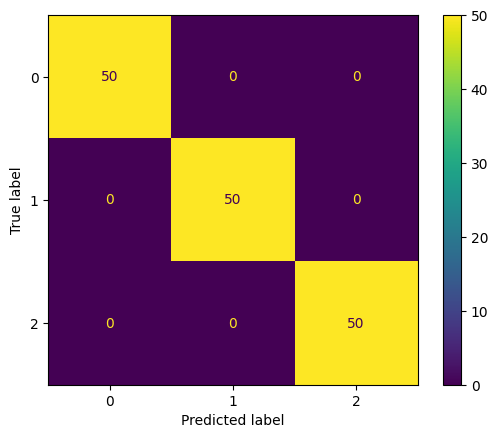

array([[50,  0,  0],
       [ 0, 50,  0],
       [ 0,  0, 50]], dtype=int64)

In [19]:
print('Recall:', calculate_recall(y, y_pred, 'weighted'))
print('Precision:',calculate_precision(y, y_pred, 'weighted'))
print('F1 score:',calculate_f1(y, y_pred, 'weighted'))
calculate_confusion_matrix(y, y_pred)

### Train-test 70-30 - k=1

In [20]:
x_train, x_test, y_train, y_test = split_train_test(X, y, 0.3)

Recall: 1.0
Precision: 1.0
F1 score: 1.0


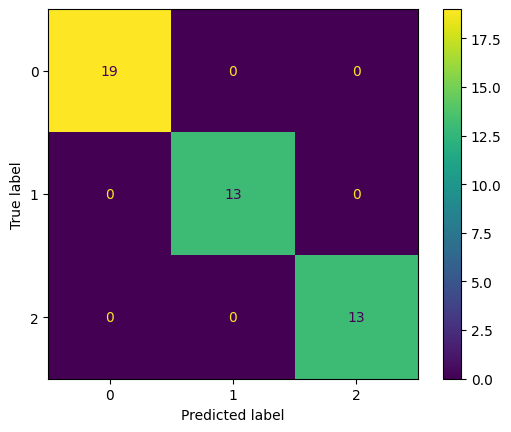

array([[19,  0,  0],
       [ 0, 13,  0],
       [ 0,  0, 13]], dtype=int64)

In [21]:
model = KNeighborsClassifier(n_neighbors=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('Recall:', calculate_recall(y_test, y_pred, 'weighted'))
print('Precision:',calculate_precision(y_test, y_pred, 'weighted'))
print('F1 score:',calculate_f1(y_test, y_pred, 'weighted'))
calculate_confusion_matrix(y_test, y_pred)

### 10CV - k=1

In [133]:
def cross_validation_test(iters, X, y, k_folds=10):
    iters_recalls = []
    iters_precisions = []
    iters_f1_scores = []
    x_train, x_test, y_train, y_test = split_k_fold(X, y, k_folds)
    for iter in range(iters):
        recalls = []
        precisions = []
        f1_scores = []
        for i in range(len(x_train)):
            model = KNeighborsClassifier(n_neighbors=iter+1)
            model.fit(x_train[i], y_train[i])
            y_pred = model.predict(x_test[i])

            recalls.append(calculate_recall(y_test[i], y_pred))
            precisions.append(calculate_precision(y_test[i], y_pred))
            f1_scores.append(calculate_f1(y_test[i], y_pred))
        r_mean = np.mean(recalls)
        p_mean = np.mean(precisions)
        f_mean = np.mean(f1_scores)
        print(f'********* Averages - k={iter+1} **********')
        print('Recall:', r_mean)
        print('Precision:',p_mean)
        print('F1 Score:', f_mean)

        iters_recalls.append(r_mean)
        iters_precisions.append(p_mean)
        iters_f1_scores.append(f_mean)
    if iters > 1:
        plot_measures(iters_recalls, iters_precisions, iters_f1_scores)
        print('Best k')
        print('Recall: ', np.argmax(iters_recalls)+1)
        print('Precision: ', np.argmax(iters_precisions)+1)
        print('F1-Score: ', np.argmax(iters_f1_scores)+1)
        return np.argmax(f1_scores)+1
    return None


In [82]:
bests = cross_validation_test(1, X, y)

********* Averages - k=1 **********
Recall: 0.9607936507936509
Precision: 0.9615079365079366
F1 Score: 0.9588337588337589


In [25]:
def avg_confusion_matrix(confusion_matrices, display=True):
    avg_cm = confusion_matrices[0]
    for i in range(1, len(confusion_matrices)):
        avg_cm += confusion_matrices[i]
    avg_cm = avg_cm / len(confusion_matrices)
    if display:
        display_confusion_matrix(avg_cm, None)
    return avg_cm

### Train only - multiple k values

In [122]:
def train_only_test(iters, X, y):
    recalls = []
    precisions = []
    f1_scores = []
    for i in range(15):
        model = KNeighborsClassifier(n_neighbors = i+1)
        model.fit(X, y)
        y_pred = model.predict(X)
        recall = calculate_recall(y, y_pred, 'weighted')
        recalls.append(recall)
        precision = calculate_precision(y, y_pred,  'weighted')
        precisions.append(precision)
        f1 = calculate_f1(y, y_pred,  'weighted')
        f1_scores.append(f1)
        print(f'********* Averages - k={i+1} **********')
        print('Recall:', recall)
        print('Precision:',precision)
        print('F1 Score:', f1)
    if iters > 1:
        plot_measures(recalls, precisions, f1_scores)
        print('Best k')
        print('Recall: ', np.argmax(recalls)+1)
        print('Precision: ', np.argmax(precisions)+1)
        print('F1-Score: ', np.argmax(f1_scores)+1)
        return np.argmax(f1_scores)+1

********* Averages - k=1 **********
Recall: 1.0
Precision: 1.0
F1 Score: 1.0
********* Averages - k=2 **********
Recall: 0.98
Precision: 0.9811320754716981
F1 Score: 0.9799819837854068
********* Averages - k=3 **********
Recall: 0.96
Precision: 0.96
F1 Score: 0.96
********* Averages - k=4 **********
Recall: 0.96
Precision: 0.96
F1 Score: 0.96
********* Averages - k=5 **********
Recall: 0.9666666666666667
Precision: 0.9667867146858743
F1 Score: 0.9666633329999667
********* Averages - k=6 **********
Recall: 0.9733333333333334
Precision: 0.9733333333333334
F1 Score: 0.9733333333333334
********* Averages - k=7 **********
Recall: 0.9733333333333334
Precision: 0.9738247863247864
F1 Score: 0.9733226623982927
********* Averages - k=8 **********
Recall: 0.98
Precision: 0.980125383486728
F1 Score: 0.9799979997999799
********* Averages - k=9 **********
Recall: 0.98
Precision: 0.980125383486728
F1 Score: 0.9799979997999799
********* Averages - k=10 **********
Recall: 0.98
Precision: 0.980125383486

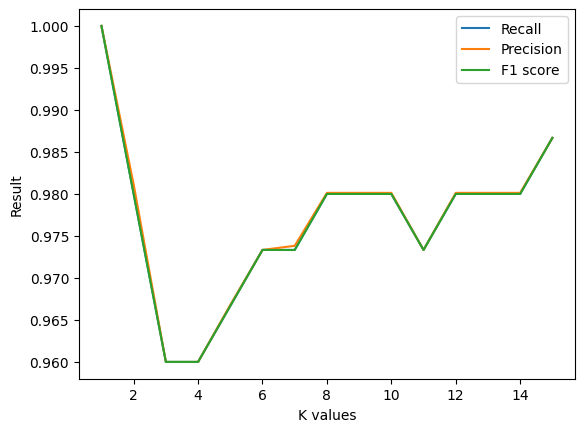

Best k
Recall:  1
Precision:  1
F1-Score:  1


In [123]:
best_k_train_only = train_only_test(15, X, y)

In [90]:
model = KNeighborsClassifier(n_neighbors=best_k_train_only)
model.fit(X, y)
y_pred = model.predict(X)

Recall: 1.0
Precision: 1.0
F-Score: 1.0


<Figure size 640x480 with 0 Axes>

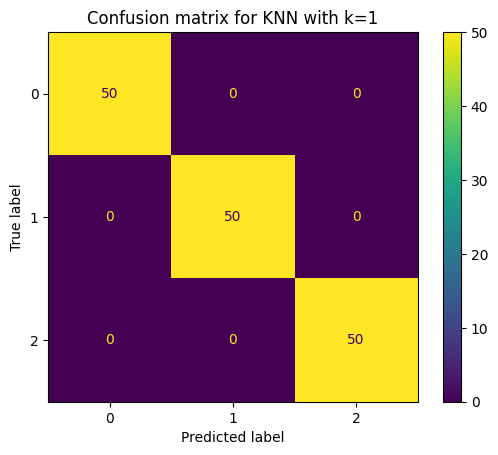

array([[50,  0,  0],
       [ 0, 50,  0],
       [ 0,  0, 50]], dtype=int64)

In [92]:
print('Recall:', calculate_recall(y, y_pred, 'weighted'))
print('Precision:', calculate_precision(y, y_pred, 'weighted'))
print('F-Score:', calculate_f1(y, y_pred, 'weighted'))
calculate_confusion_matrix(y, y_pred, title=f'Confusion matrix for KNN with k={best_k_train_only}')

### TVT 40-30-30 - multiple k values

In [128]:
x_train, x_val, x_test, y_train, y_val, y_test = split_train_test_validation(X, y)

In [129]:
def tvt_test(iters, x_train, x_val, y_train, y_val):
    recalls = []
    precisions = []
    f1_scores = []
    for i in range(iters):
        model = KNeighborsClassifier(n_neighbors=i+1)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_val)
        recall = calculate_recall(y_val, y_pred, 'weighted')
        recalls.append(recall)
        precision = calculate_precision(y_val, y_pred,  'weighted')
        precisions.append(precision)
        f1 = calculate_f1(y_val, y_pred,  'weighted')
        f1_scores.append(f1)
        print(f'********* Averages - k={i+1} **********')
        print('Recall:', recall)
        print('Precision:',precision)
        print('F1 Score:', f1)

    if iters > 1:
        plot_measures(recalls, precisions, f1_scores)
        print('Best k')
        print('Recall: ', np.argmax(recalls)+1)
        print('Precision: ', np.argmax(precisions)+1)
        print('F1-Score: ', np.argmax(f1_scores)+1)
        return np.argmax(f1_scores)+1

********* Averages - k=1 **********
Recall: 0.9111111111111111
Precision: 0.9163398692810457
F1 Score: 0.9114197530864196
********* Averages - k=2 **********
Recall: 0.8888888888888888
Precision: 0.899537037037037
F1 Score: 0.8891774891774892
********* Averages - k=3 **********
Recall: 0.8888888888888888
Precision: 0.899537037037037
F1 Score: 0.8891774891774892
********* Averages - k=4 **********
Recall: 0.8888888888888888
Precision: 0.899537037037037
F1 Score: 0.8891774891774892
********* Averages - k=5 **********
Recall: 0.8888888888888888
Precision: 0.899537037037037
F1 Score: 0.8891774891774892
********* Averages - k=6 **********
Recall: 0.8888888888888888
Precision: 0.899537037037037
F1 Score: 0.8891774891774892
********* Averages - k=7 **********
Recall: 0.9111111111111111
Precision: 0.9163398692810457
F1 Score: 0.9114197530864196
********* Averages - k=8 **********
Recall: 0.9111111111111111
Precision: 0.9298245614035088
F1 Score: 0.9111111111111111
********* Averages - k=9 ****

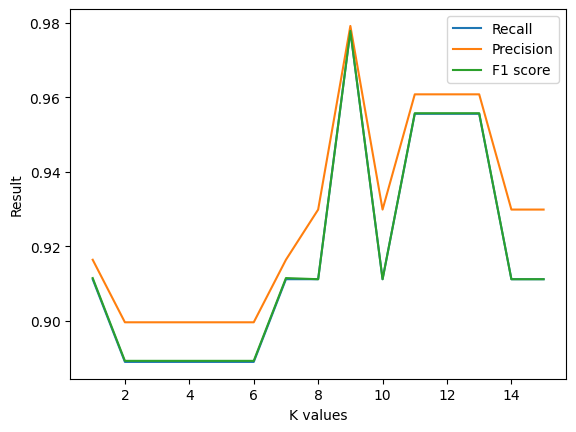

Best k
Recall:  9
Precision:  9
F1-Score:  9


In [130]:
best_k = tvt_test(15, x_train, x_val, y_train, y_val)

#### retrain the model using the best k

In [70]:
x_train_total = pd.concat([x_train, x_val], ignore_index=True)
y_train_total = pd.concat([y_train, y_val], ignore_index=True)

In [71]:
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(x_train_total, y_train_total)
y_pred = model.predict(x_test)

Recall: 1.0
Precision: 1.0
F-Score: 1.0


<Figure size 640x480 with 0 Axes>

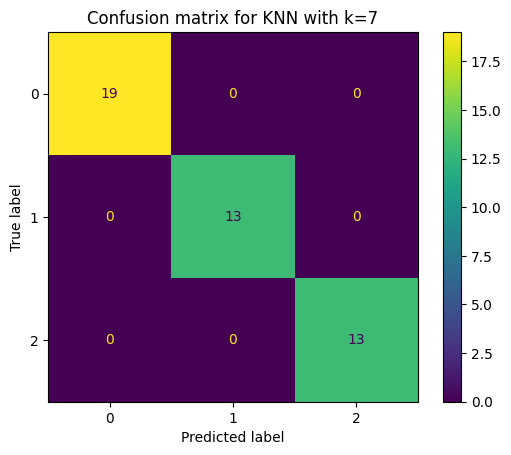

array([[19,  0,  0],
       [ 0, 13,  0],
       [ 0,  0, 13]], dtype=int64)

In [72]:
print('Recall:', calculate_recall(y_test, y_pred, 'weighted'))
print('Precision:', calculate_precision(y_test, y_pred, 'weighted'))
print('F-Score:', calculate_f1(y_test, y_pred, 'weighted'))
calculate_confusion_matrix(y_test, y_pred, title=f'Confusion matrix for KNN with k={best_k}')

### 10 CV - multiple k values

********* Averages - k=1 **********
Recall: 0.9607936507936509
Precision: 0.9615079365079366
F1 Score: 0.9588337588337589
********* Averages - k=2 **********
Recall: 0.9541269841269842
Precision: 0.9548412698412698
F1 Score: 0.9514263514263513
********* Averages - k=3 **********
Recall: 0.9663492063492064
Precision: 0.9738095238095238
F1 Score: 0.964938764938765
********* Averages - k=4 **********
Recall: 0.9663492063492064
Precision: 0.9738095238095238
F1 Score: 0.964938764938765
********* Averages - k=5 **********
Recall: 0.9730158730158731
Precision: 0.9785714285714285
F1 Score: 0.9712065712065712
********* Averages - k=6 **********
Recall: 0.9596825396825397
Precision: 0.9671428571428572
F1 Score: 0.9575313575313575
********* Averages - k=7 **********
Recall: 0.9552380952380953
Precision: 0.9585714285714285
F1 Score: 0.9487991637991638
********* Averages - k=8 **********
Recall: 0.9735714285714286
Precision: 0.979047619047619
F1 Score: 0.973870573870574
********* Averages - k=9 ***

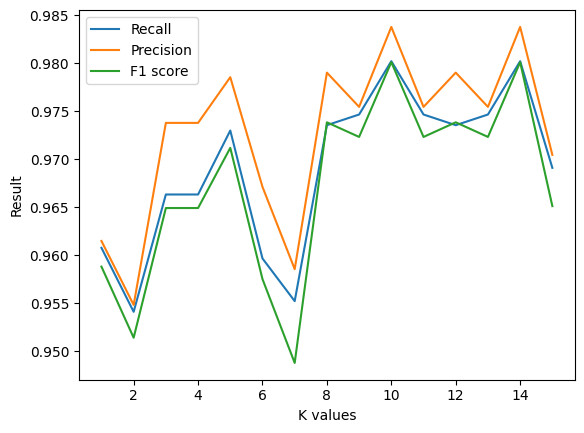

Best k
Recall:  10
Precision:  10
F1-Score:  10


In [134]:
best_k_cv = cross_validation_test(15, X, y, k_folds=10)

Como se pode observar, o k=10 é o obtem melhores resultados na classificação dos modelos. Assim, o modelo será novamente re-treinado utilizando este valor

In [ ]:
# TODO: verificar como re-treinar o modelo

KNN - com um K pequeno, o modelo fica mais sensivel a ruido e a overfitting
Quando usamos um K grande, fica pouco sensivel

Usar k impar sempre que temos um numero classes par 

## ReliefF - EX.2.2

In [135]:
from skfeature.function.similarity_based import fisher_score, reliefF

In [136]:
def plot_elbow(f1_scores, k_model, metric):
    f1_scores = [0] + f1_scores
    plt.figure()
    plt.plot(np.arange(len(f1_scores)), f1_scores, '*-')
    plt.ylim(0, 1)
    plt.xlim(0, len(f1_scores))
    plt.title(f'Plot with the features used, using the model KNN with k={k_model}, features ranked using {metric}')
    plt.ylabel(f'F1 score')
    plt.xlabel(f'Nº features used')
    plt.show()

In [137]:
def best_model_feature_and_k(X, y, function='reliefF'):
    x_train_total, x_test, y_train_total, y_test = split_train_test(X, y, 0.3)
    x_train, x_val, y_train, y_val = split_train_test(x_train_total, y_train_total, 0.3)

    if function == 'reliefF':
        # ReliefF
        print('reliefF')
        score = reliefF.reliefF(x_train.to_numpy(), y_train.to_numpy())
    else:
        # fisher
        print('fisher')
        score = fisher_score.fisher_score(x_train.to_numpy(), y_train.to_numpy())
    
    features_ranked = (-score).argsort()
    features = x_train.columns

    print(f'Features ranked by {function}:')
    print(list(features[features_ranked]))
    print(f'Scores:')
    print(score)
    
    df = pd.DataFrame()

    max_score = 0
    best_k = 0
    best_n_features = 0

    for k in range(15):
        f1_scores = []
        for n_features in range(1, len(features_ranked)+1):
            features_to_use = features[features_ranked][:n_features+1]
            model = KNeighborsClassifier(n_neighbors=k+1)
            model.fit(x_train[features_to_use], y_train)
            y_pred = model.predict(x_val[features_to_use])
            f1 = calculate_f1(y_val, y_pred,  'weighted')
            if f1 > max_score:
                max_score = f1
                best_k = k+1
                best_n_features = n_features
            f1_scores.append(f1)
        df[f'K{k+1}'] = pd.Series(np.array(f1_scores))
        plot_elbow(f1_scores, k+1, function)
    df = df.set_index(np.arange(1, len(features)+1))
    print('Max f1-score: ', max_score)
    print('Model used: ', best_k)
    print('Best number features:', best_n_features)
    return df

reliefF
Features ranked by reliefF:
['petal length (cm)', 'petal width (cm)', 'sepal length (cm)', 'sepal width (cm)']
Scores:
[210.09906268 146.54576353 663.85612536 296.19711111]


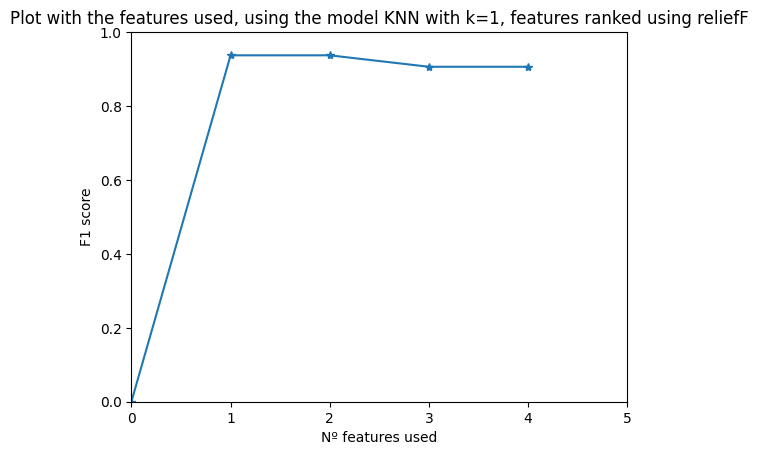

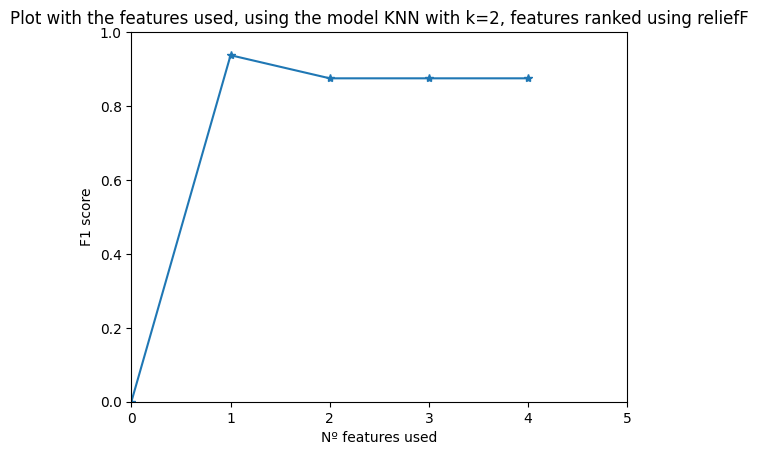

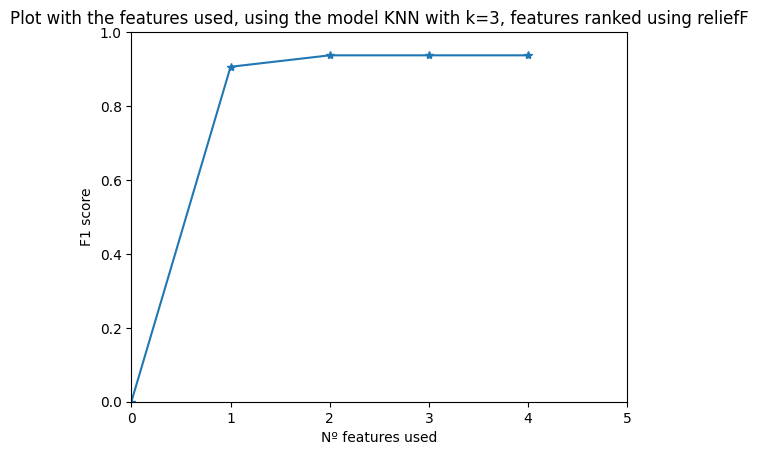

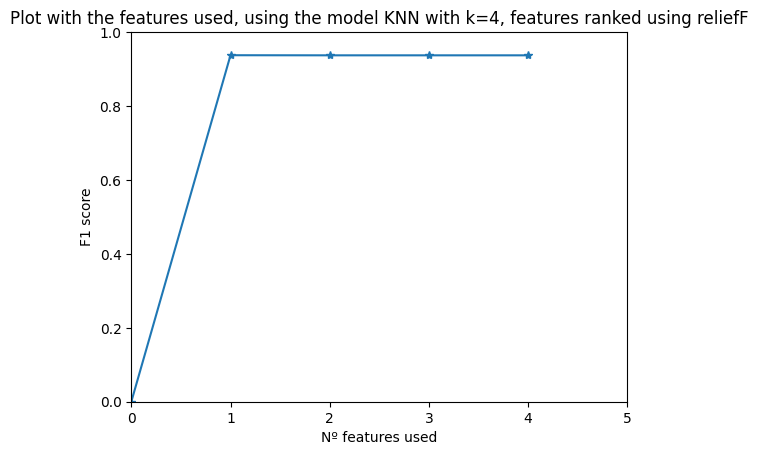

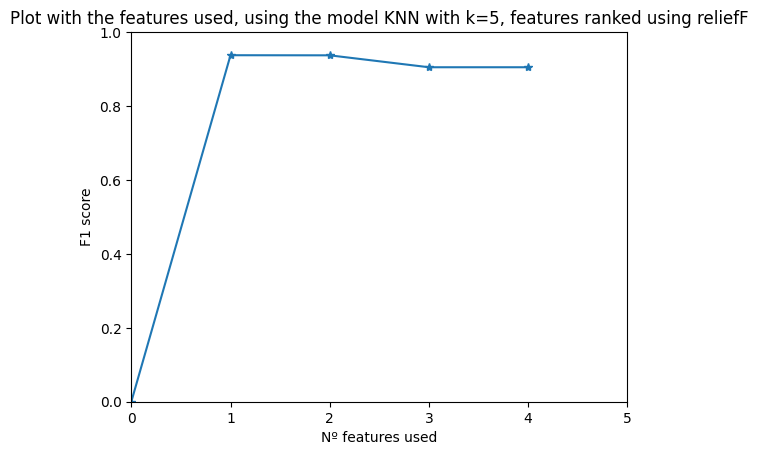

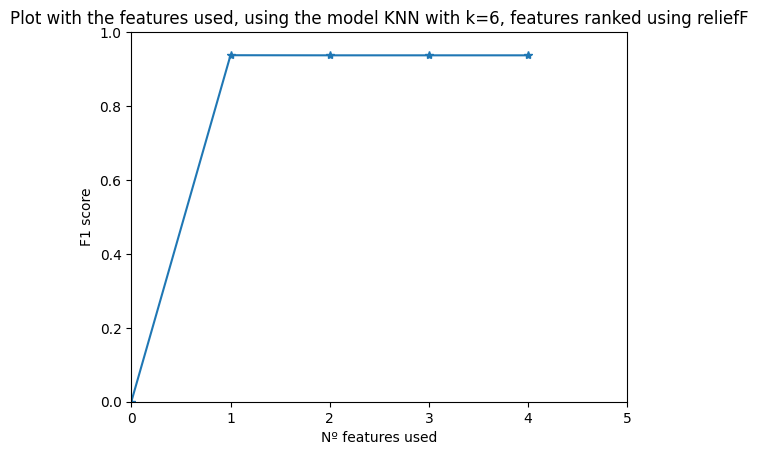

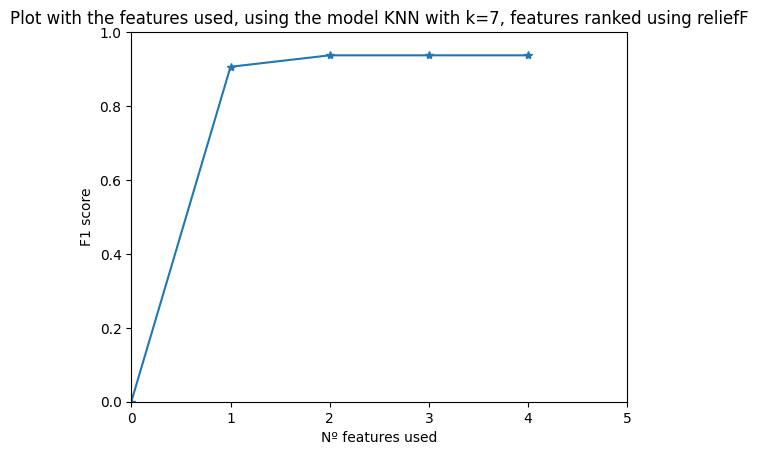

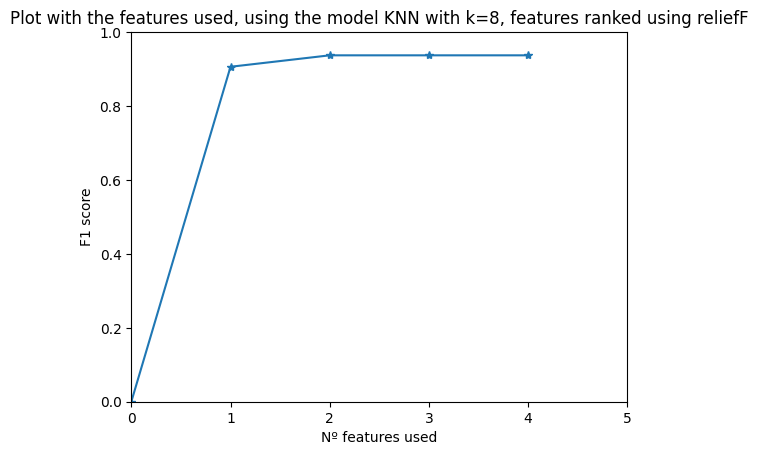

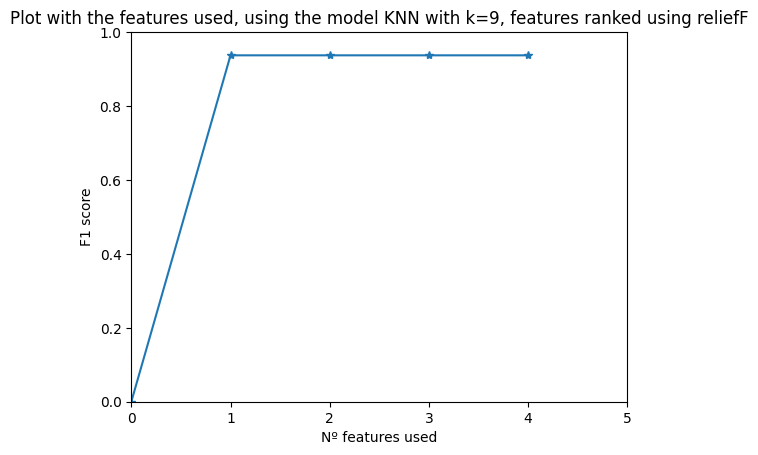

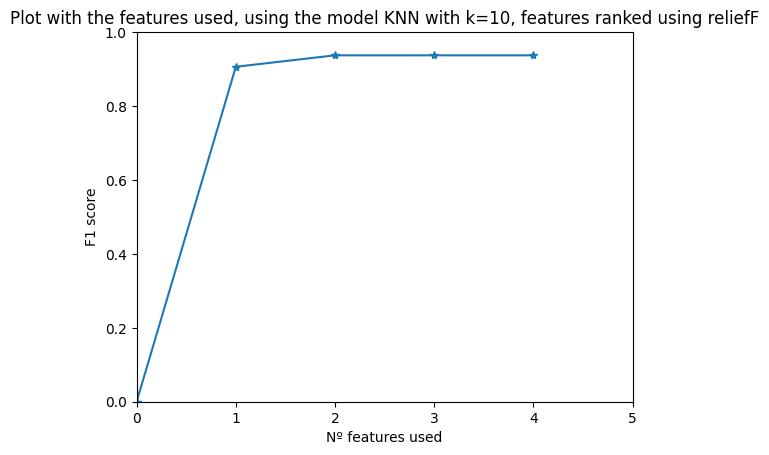

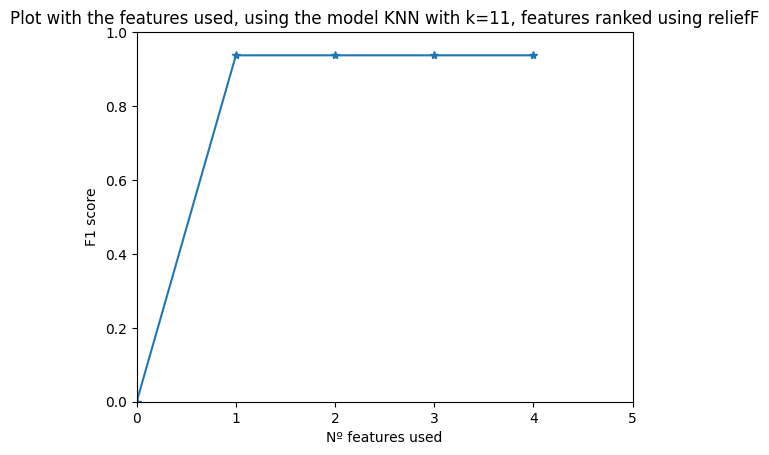

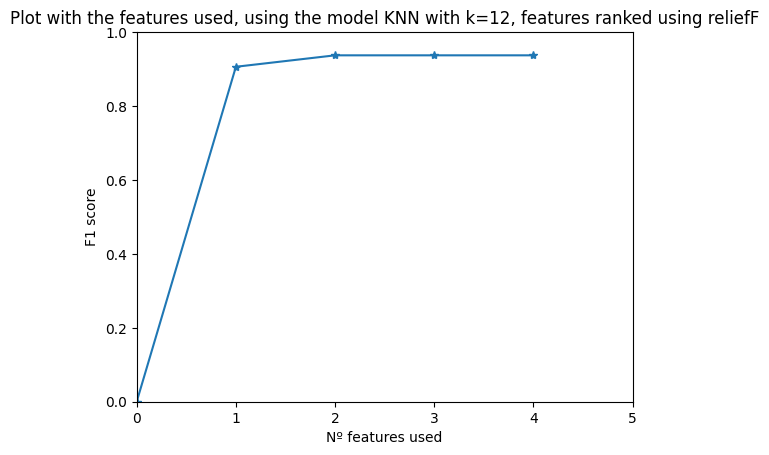

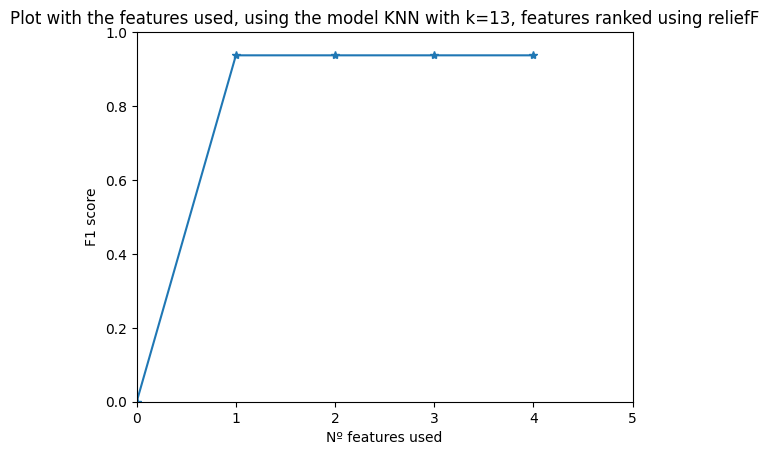

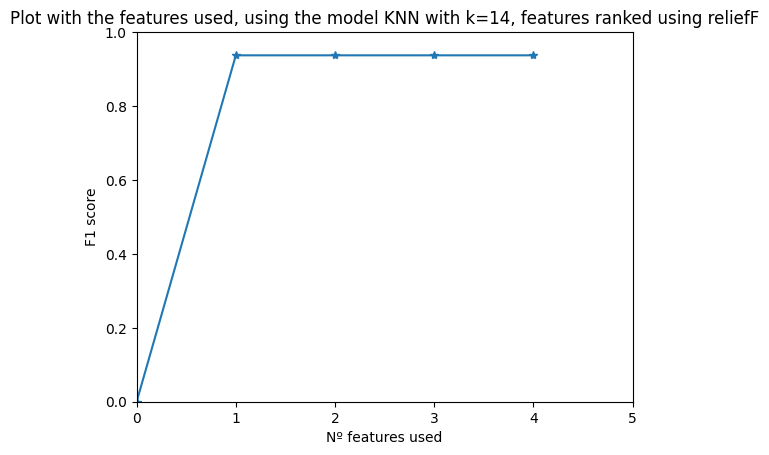

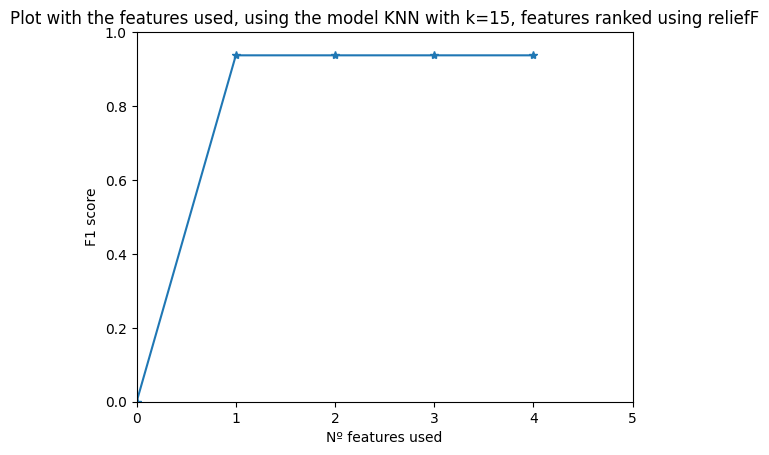

Max f1-score:  0.9375
Model used:  2
Best number features: 1


,K1,K2,K3,K4,K5,K6,K7,K8,K9,K10,K11,K12,K13,K14,K15
1,0.937216,0.9375,0.906250,0.937500,0.937500,0.937500,0.906250,0.906250,0.937216,0.906250,0.937216,0.906250,0.937216,0.937216,0.937216
2,0.937216,0.8750,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216
3,0.906250,0.8750,0.937216,0.937216,0.904963,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216
4,0.906250,0.8750,0.937216,0.937216,0.904963,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216


In [138]:
best_model_feature_and_k(X, y)

fisher
Features ranked by fisher:
['petal length (cm)', 'petal width (cm)', 'sepal length (cm)', 'sepal width (cm)']
Scores:
[ 1.27439663  1.01228719 14.9823551  10.4969833 ]


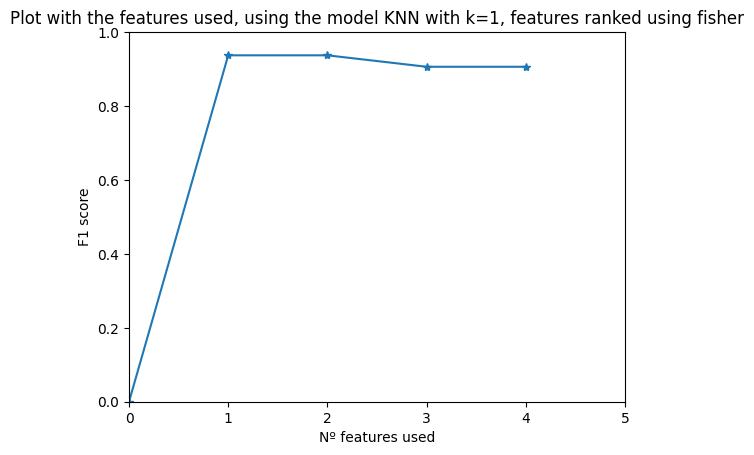

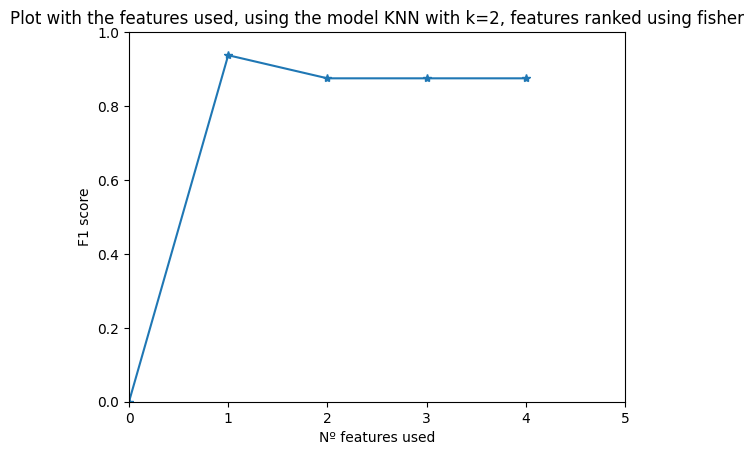

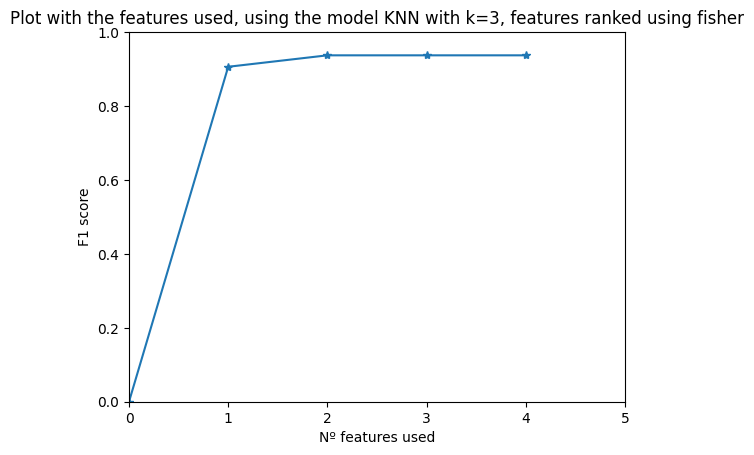

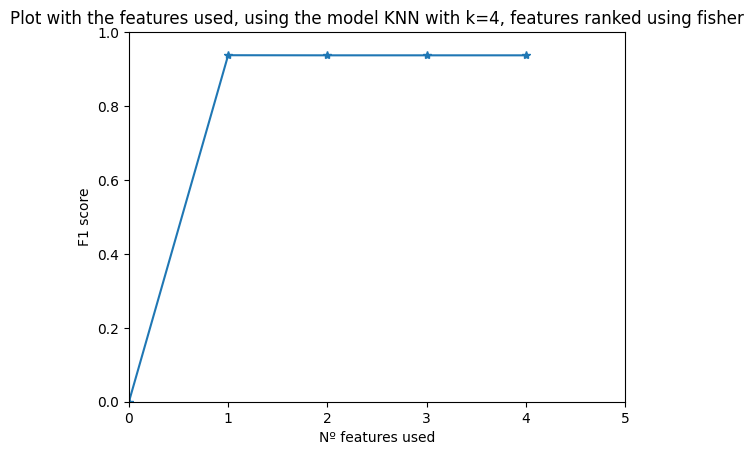

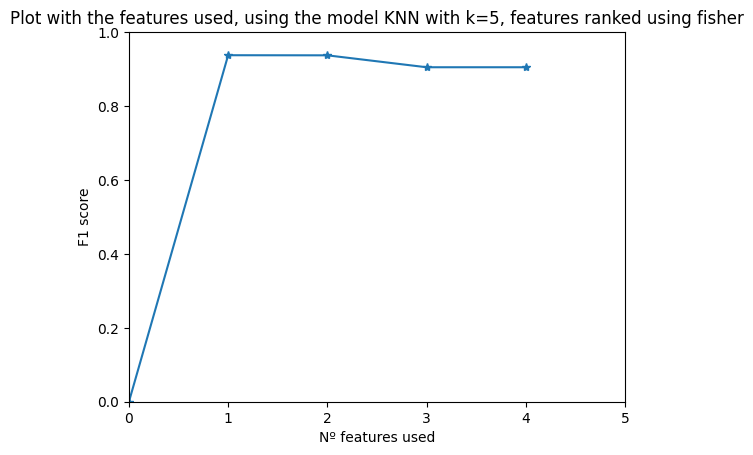

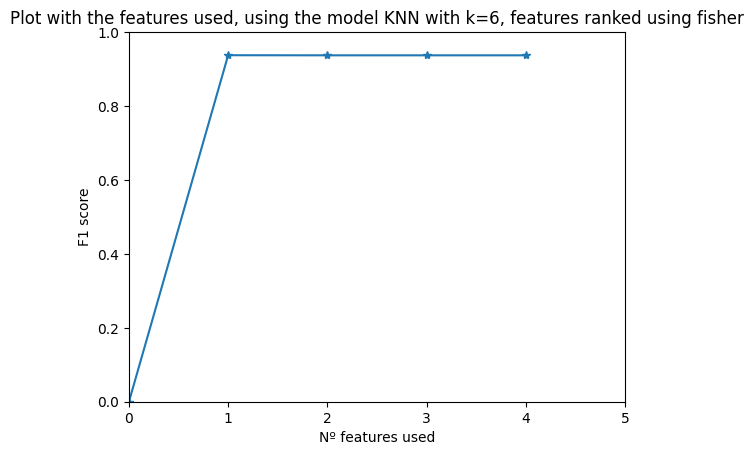

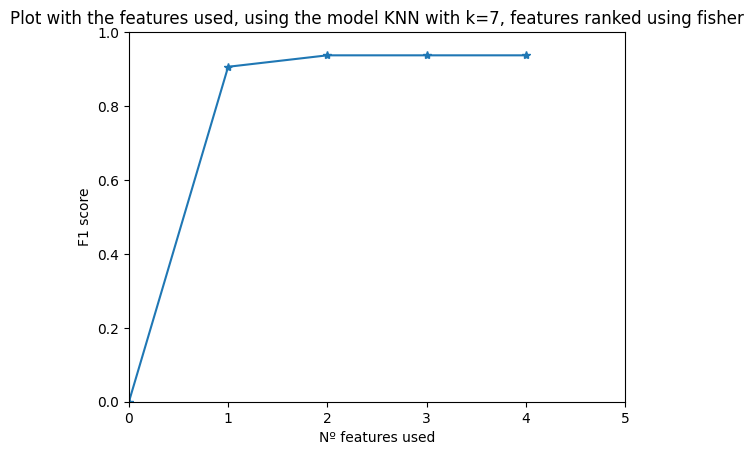

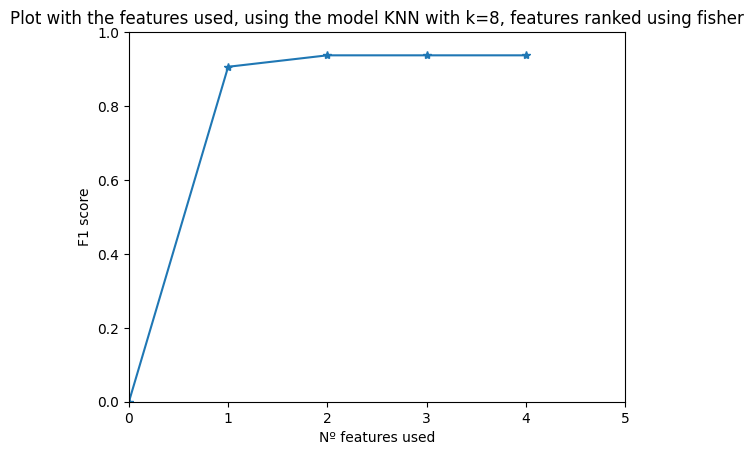

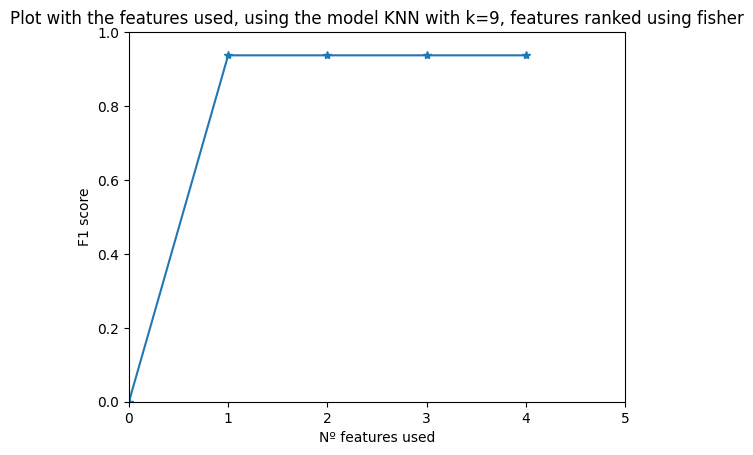

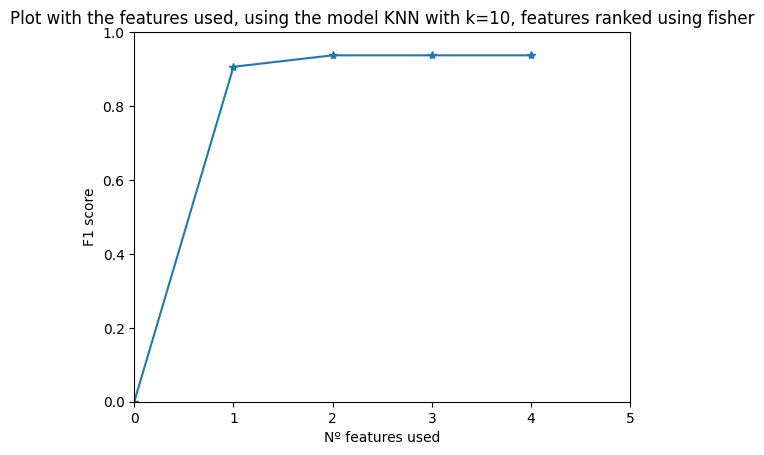

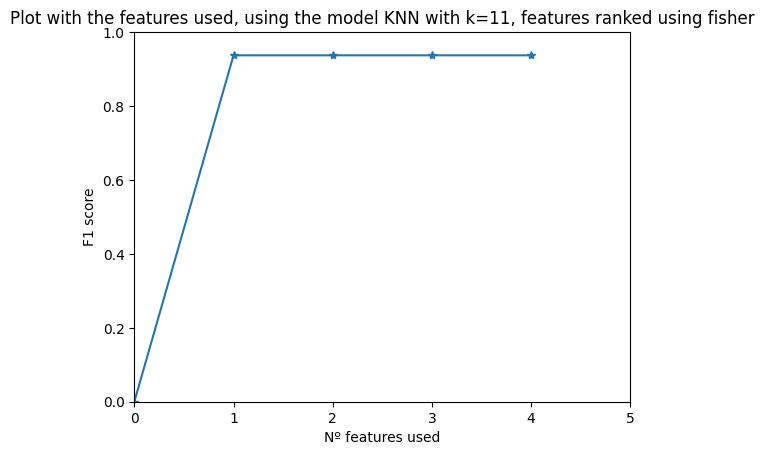

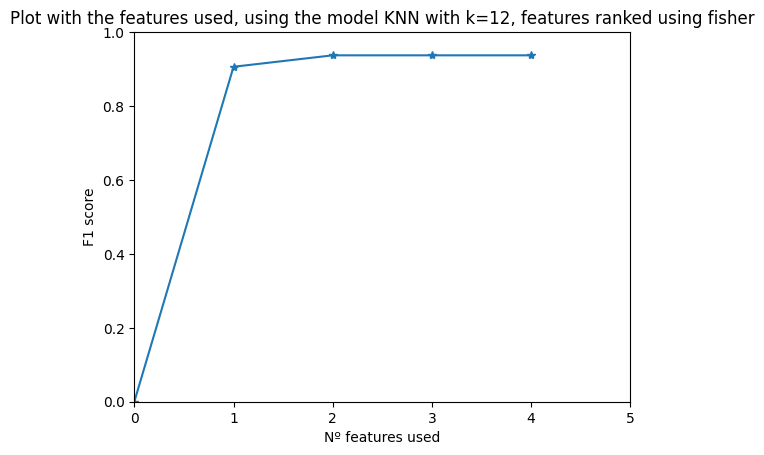

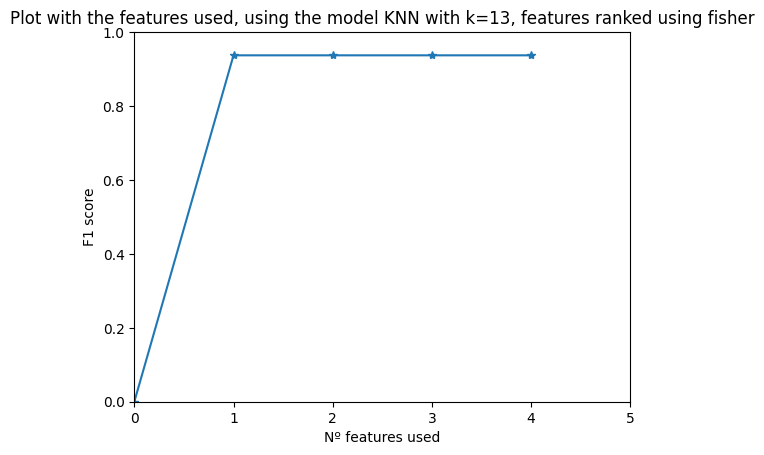

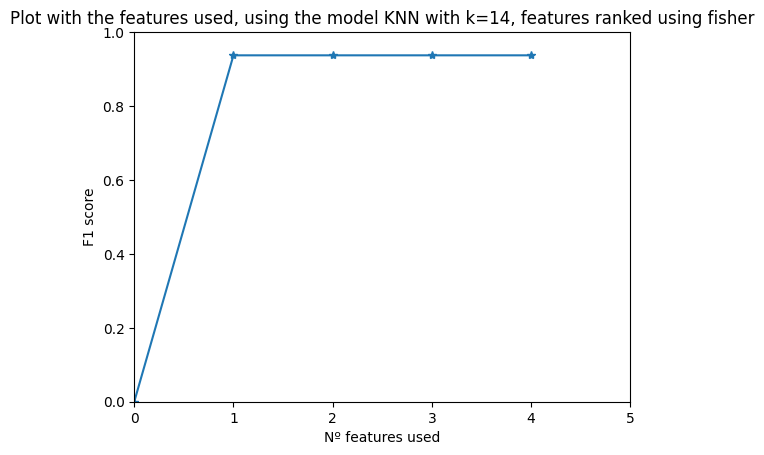

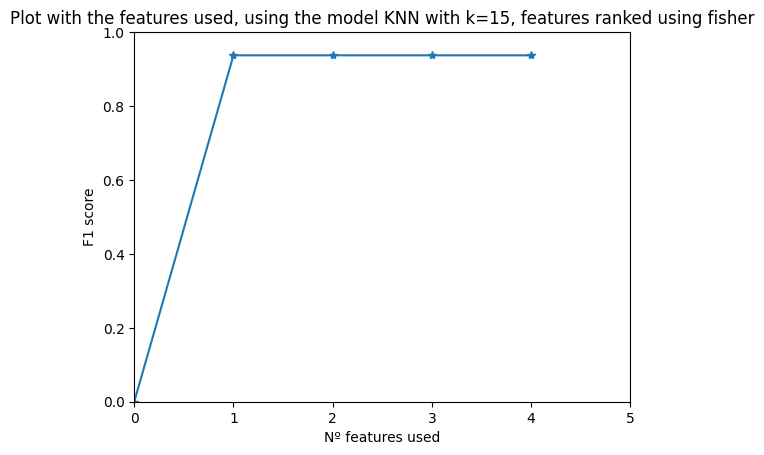

Max f1-score:  0.9375
Model used:  2
Best number features: 1


,K1,K2,K3,K4,K5,K6,K7,K8,K9,K10,K11,K12,K13,K14,K15
1,0.937216,0.9375,0.906250,0.937500,0.937500,0.937500,0.906250,0.906250,0.937216,0.906250,0.937216,0.906250,0.937216,0.937216,0.937216
2,0.937216,0.8750,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216
3,0.906250,0.8750,0.937216,0.937216,0.904963,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216
4,0.906250,0.8750,0.937216,0.937216,0.904963,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216,0.937216


In [139]:
best_model_feature_and_k(X, y, 'fisher')